# CVE Data Creator for Graph Analytics
**Quick data setup for Lecture 20 GraphFrames demo**

This notebook downloads and prepares CVEs for all of 2024!

In [0]:
# Simple setup - download CVE data and prepare bronze layers
import os
import json
import zipfile
import urllib.request
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

print("🚀 Setting up CVE data for Graph Analytics demo...")

# Configuration for graph demo
CATALOG = "workspace"
SCHEMA = "default"
DELTA_BRONZE_2024_PATH = f"/Volumes/{CATALOG}/{SCHEMA}/cve_demo/bronze/2024_Nov13"

print(f"📁 2024 data will go to: {DELTA_BRONZE_2024_PATH}")


🚀 Setting up CVE data for Graph Analytics demo...
📁 2024 data will go to: /Volumes/workspace/default/cve_demo/bronze/2024_Nov13


In [0]:
# Download CVE repository
print("📥 Downloading CVE repository...")

zip_dest = "/tmp/cve_graph_demo/cvelistV5.zip"
extract_dir = "/tmp/cve_graph_demo/cvelistV5-main"

# Create directories
os.makedirs("/tmp/cve_graph_demo", exist_ok=True)

# Download the repository
zip_url = "https://github.com/CVEProject/cvelistV5/archive/refs/heads/main.zip"
print(f"📥 Downloading from: {zip_url}")

with urllib.request.urlopen(zip_url) as response:
    data = response.read()
    
with open(zip_dest, "wb") as f:
    f.write(data)

print(f"✅ Downloaded {len(data):,} bytes")

# Extract the ZIP
print("📦 Extracting ZIP archive...")
with zipfile.ZipFile(zip_dest) as z:
    z.extractall("/tmp/cve_graph_demo/")

print("✅ Extraction complete")

📥 Downloading CVE repository...
📥 Downloading from: https://github.com/CVEProject/cvelistV5/archive/refs/heads/main.zip
✅ Downloaded 524,646,384 bytes
📦 Extracting ZIP archive...
✅ Extraction complete


In [0]:
# Process 2024 CVEs
print("🎯 Processing 2024 CVEs...")

def process_year_cves(year, max_files=100000):
    """Process CVEs for a specific year, limiting to max_files"""
    
    cve_year_dir = f"{extract_dir}/cves/{year}"
    json_files = []
    
    print(f"📂 Scanning directory: {cve_year_dir}")
    
    if os.path.exists(cve_year_dir):
        file_count = 0
        for root, dirs, files in os.walk(cve_year_dir):
            for file in files:
                if file.endswith('.json') and f'CVE-{year}-' in file and file_count < max_files:
                    file_path = os.path.join(root, file)
                    
                    try:
                        # Read and validate JSON
                        with open(file_path, 'r', encoding='utf-8') as f:
                            content = f.read()
                            cve_data = json.loads(content)
                            json_files.append(cve_data)
                            
                        file_count += 1
                        
                        if file_count % 500 == 0:
                            print(f"   📊 Processed {file_count} CVE-{year} files...")
                            
                    except Exception as e:
                        print(f"⚠️ Skipped {file}: {e}")
                        continue
                        
        print(f"✅ Collected {len(json_files)} CVEs from {year}")
        return json_files
    else:
        print(f"❌ Directory not found: {cve_year_dir}")
        return []

# Process both years
cves_2024 = process_year_cves(2024, 100000)

print(f"📊 Total 2024 CVEs: {len(cves_2024)}")


🎯 Processing 2024 CVEs...
📂 Scanning directory: /tmp/cve_graph_demo/cvelistV5-main/cves/2024
   📊 Processed 500 CVE-2024 files...
   📊 Processed 1000 CVE-2024 files...
   📊 Processed 1500 CVE-2024 files...
   📊 Processed 2000 CVE-2024 files...
   📊 Processed 2500 CVE-2024 files...
   📊 Processed 3000 CVE-2024 files...
   📊 Processed 3500 CVE-2024 files...
   📊 Processed 4000 CVE-2024 files...
   📊 Processed 4500 CVE-2024 files...
   📊 Processed 5000 CVE-2024 files...
   📊 Processed 5500 CVE-2024 files...
   📊 Processed 6000 CVE-2024 files...
   📊 Processed 6500 CVE-2024 files...
   📊 Processed 7000 CVE-2024 files...
   📊 Processed 7500 CVE-2024 files...
   📊 Processed 8000 CVE-2024 files...
   📊 Processed 8500 CVE-2024 files...
   📊 Processed 9000 CVE-2024 files...
   📊 Processed 9500 CVE-2024 files...
   📊 Processed 10000 CVE-2024 files...
   📊 Processed 10500 CVE-2024 files...
   📊 Processed 11000 CVE-2024 files...
   📊 Processed 11500 CVE-2024 files...
   📊 Processed 12000 CVE-2024 

In [0]:
import json
import pandas as pd
from pyspark.sql.functions import current_timestamp, current_date, lit, monotonically_increasing_id

def save_cves_to_delta_serverless(cves_list, year, delta_path):
    """Save CVEs to Delta Lake bronze layer - SERVERLESS COMPATIBLE"""
    if not cves_list:
        print(f"⚠️ No CVEs to save for {year}")
        return
    
    print(f"📊 Converting {len(cves_list)} CVEs to DataFrame...")
    pdf = pd.DataFrame(cves_list)
    
    # Convert 'containers' dictionary to JSON string for Arrow compatibility
    if "containers" in pdf.columns:
        pdf["containers"] = pdf["containers"].apply(
            lambda x: json.dumps(x) if x is not None else None
        )
    
    # Convert any other potentially problematic nested columns
    # Check for other nested structures that might cause issues
    for col in pdf.columns:
        if pdf[col].dtype == 'object':
            # Check if first non-null value is dict or list
            first_val = pdf[col].dropna().iloc[0] if not pdf[col].dropna().empty else None
            if isinstance(first_val, (dict, list)):
                print(f"Converting nested column '{col}' to JSON string")
                pdf[col] = pdf[col].apply(
                    lambda x: json.dumps(x) if x is not None else None
                )
    
    df_raw = spark.createDataFrame(pdf)
    
    df_bronze = (
        df_raw
        .withColumn("_ingestion_timestamp", current_timestamp())
        .withColumn("_ingestion_date", current_date())
        .withColumn("_year", lit(year))
        .withColumn("_record_id", monotonically_increasing_id())
    )
    
    record_count = df_bronze.count()
    print(f"📈 {year} CVE records: {record_count:,}")
    
    (
        df_bronze.write
        .format("delta")
        .mode("overwrite")
        .option("mergeSchema", "true")
        .option("overwriteSchema", "true")
        .option("delta.columnMapping.mode", "name")
        .save(delta_path)
    )
    
    print(f"✅ {year} Bronze layer created: {delta_path}")
    return df_bronze

df_2024 = save_cves_to_delta_serverless(cves_2024, 2024, DELTA_BRONZE_2024_PATH)

📊 Converting 38753 CVEs to DataFrame...
Converting nested column 'cveMetadata' to JSON string
📈 2024 CVE records: 38,753
✅ 2024 Bronze layer created: /Volumes/workspace/default/cve_demo/bronze/2024_Nov13


In [0]:
  # Verify the Bronze layer data
  print("🔍 Verifying Bronze layer data...")

  # Display DataFrame statistics
  record_count = df_2024.count()
  column_count = len(df_2024.columns)
  print(f"📊 Total records: {record_count:,}")
  print(f"📊 Total columns: {column_count}")

  # Test loading the bronze data for verification
  try:
      # Load the Delta table we just created
      bronze_2024 = spark.read.format("delta").load(DELTA_BRONZE_2024_PATH)

      print(f"✅ 2024 Bronze data loaded: {bronze_2024.count():,} records")

      # Check the actual schema first
      print("\n📋 Actual schema structure:")
      bronze_2024.printSchema()

      # Show sample data - use columns that exist as strings
      print("\n🔍 Sample 2024 data (available fields):")

      # Since cveMetadata is a JSON string, we need to parse it or just show raw columns
      from pyspark.sql.functions import get_json_object

      bronze_2024.select(
          get_json_object(col("cveMetadata"), "$.cveId").alias("cve_id"),
          get_json_object(col("cveMetadata"), "$.datePublished").alias("date_published"),
          col("_year").alias("year"),
          col("_ingestion_timestamp").alias("ingested_at")
      ).show(5, truncate=False)

      # Show available top-level columns
      print(f"\n📊 Available columns: {bronze_2024.columns}")

      print(f"\n🚀 SUCCESS! Bronze layer ready for Silver transformation!")
      print(f"📁 Bronze path: {DELTA_BRONZE_2024_PATH}")
      print(f"📋 Registered table: cve_bronze_2024")
      print(f"\n👉 Query with: SELECT * FROM cve_bronze_2024 LIMIT 10")
      print(f"💡 Note: cveMetadata is stored as JSON string - parse in Silver layer")

  except Exception as e:
      print(f"❌ Error verifying Bronze data: {e}")
      print("Showing basic table info instead...")

      # Fallback - just show basic info
      try:
          bronze_2024 = spark.read.format("delta").load(DELTA_BRONZE_2024_PATH)
          print(f"✅ Table exists with {bronze_2024.count():,} records")
          print(f"📊 Columns: {len(bronze_2024.columns)}")
          print("👉 Use Silver layer to parse JSON fields properly")
      except Exception as e2:
          print(f"❌ Complete failure: {e2}")

🔍 Verifying Bronze layer data...
📊 Total records: 38,753
📊 Total columns: 8
✅ 2024 Bronze data loaded: 38,753 records

📋 Actual schema structure:
root
 |-- dataType: string (nullable = true)
 |-- cveMetadata: string (nullable = true)
 |-- containers: string (nullable = true)
 |-- dataVersion: string (nullable = true)
 |-- _ingestion_timestamp: timestamp (nullable = true)
 |-- _ingestion_date: date (nullable = true)
 |-- _year: integer (nullable = true)
 |-- _record_id: long (nullable = true)


🔍 Sample 2024 data (available fields):
+--------------+------------------------+----+--------------------------+
|cve_id        |date_published          |year|ingested_at               |
+--------------+------------------------+----+--------------------------+
|CVE-2024-10286|2024-10-23T12:01:40.766Z|2024|2025-11-17 08:30:44.529213|
|CVE-2024-10395|2025-02-03T06:59:21.740Z|2024|2025-11-17 08:30:44.529213|
|CVE-2024-10465|2024-10-29T12:19:15.936Z|2024|2025-11-17 08:30:44.529213|
|CVE-2024-10887|20

In [0]:
# Cleanup temporary files
print("🧹 Cleaning up temporary files...")

import shutil
try:
    shutil.rmtree("/tmp/cve_graph_demo")
    print("✅ Temporary files cleaned up")
except:
    print("📝 Temporary files will be cleaned up automatically")

print("\n🎉 CVE Data Creation Complete!")
print("🔗 Ready for Graph Analytics with GraphFrames!")

🧹 Cleaning up temporary files...
✅ Temporary files cleaned up

🎉 CVE Data Creation Complete!
🔗 Ready for Graph Analytics with GraphFrames!


Test that GraphFrames will work!

In [0]:
  # NetworkX test for Community Edition
%pip install networkx
import networkx as nx
print("🧪 Testing NetworkX graph analytics...")

try:
    import networkx as nx
    import pandas as pd
    import matplotlib.pyplot as plt

    # Create test CVE graph
    G = nx.Graph()

    # Add some test CVE nodes and vendor relationships
    cves = ["CVE-2024-001", "CVE-2024-002", "CVE-2024-003"]
    vendors = ["Apache", "Microsoft", "Google"]

    # Add nodes
    G.add_nodes_from(cves, node_type='cve')
    G.add_nodes_from(vendors, node_type='vendor')

    # Add edges (CVE affects vendor)
    G.add_edge("CVE-2024-001", "Apache")
    G.add_edge("CVE-2024-001", "Microsoft")  # CVE affects multiple vendors
    G.add_edge("CVE-2024-002", "Microsoft")
    G.add_edge("CVE-2024-003", "Google")

    # Basic graph stats
    print(f"✅ NetworkX works!")
    print(f"📊 Nodes: {G.number_of_nodes()}")
    print(f"📊 Edges: {G.number_of_edges()}")

    # Graph analytics
    print(f"📊 Graph density: {nx.density(G):.3f}")

    # Node centrality
    centrality = nx.degree_centrality(G)
    print("📊 Most connected nodes:")
    for node, cent in sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"   {node}: {cent:.3f}")

    # Find connected components
    components = list(nx.connected_components(G))
    print(f"📊 Connected components: {len(components)}")

    print("🚀 NetworkX ready for CVE graph analysis!")

except ImportError:
    print("❌ NetworkX not available - install with: pip install networkx")
except Exception as e:
    print(f"❌ NetworkX test failed: {e}")

# Test with your actual CVE data (convert Spark → pandas → NetworkX)
print("\n🧪 Testing CVE data conversion to NetworkX...")

try:
    # Load your bronze data and convert to pandas
    bronze_2024 = spark.read.format("delta").load(DELTA_BRONZE_2024_PATH)

    # Get a small sample and convert to pandas
    sample_df = bronze_2024.select(
        get_json_object(col("cveMetadata"), "$.cveId").alias("cve_id")
    ).filter(col("cve_id").isNotNull()).limit(100).toPandas()

    # Create NetworkX graph from pandas
    cve_graph = nx.Graph()

    # Add CVE nodes
    for cve in sample_df['cve_id']:
        cve_graph.add_node(cve, node_type='cve')

    print(f"✅ CVE NetworkX graph: {cve_graph.number_of_nodes()} CVE nodes")
    print("🚀 Ready to add vendor relationships and run analysis!")

except Exception as e:
    print(f"⚠️ CVE conversion needs work: {e}")
    print("💡 Use .toPandas() to convert Spark DataFrame to NetworkX")

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
🧪 Testing NetworkX graph analytics...
✅ NetworkX works!
📊 Nodes: 6
📊 Edges: 4
📊 Graph density: 0.267
📊 Most connected nodes:
   CVE-2024-001: 0.400
   Microsoft: 0.400
   CVE-2024-002: 0.200
📊 Connected components: 2
🚀 NetworkX ready for CVE graph analysis!

🧪 Testing CVE data conversion to NetworkX...
✅ CVE NetworkX graph: 100 CVE nodes
🚀 Ready to add vendor relationships and run analysis!


  Step 1: Data Exploration

  First, let's see what we're working with in terms of reserve vs publish dates. Can you run this to explore the date fields in
  your CVE data?

In [0]:
  # Step 1: Explore CVE date fields
  print("🔍 Step 1: Exploring CVE date fields...")

  # Load your bronze data
  bronze_2024 = spark.read.format("delta").load(DELTA_BRONZE_2024_PATH)

  # Extract date fields from JSON
  date_exploration = bronze_2024.select(
      get_json_object(col("cveMetadata"), "$.cveId").alias("cve_id"),
      get_json_object(col("cveMetadata"), "$.dateReserved").alias("date_reserved"),
      get_json_object(col("cveMetadata"), "$.datePublished").alias("date_published")
  ).filter(col("cve_id").isNotNull())

  # Show sample of dates
  print("📅 Sample date data:")
  date_exploration.show(10, truncate=False)

  # Check for null dates
  reserved_nulls = date_exploration.filter(col("date_reserved").isNull()).count()
  published_nulls = date_exploration.filter(col("date_published").isNull()).count()
  total_count = date_exploration.count()

  print(f"📊 Data quality check:")
  print(f"   Total CVEs: {total_count:,}")
  print(f"   Missing reserve dates: {reserved_nulls:,}")
  print(f"   Missing publish dates: {published_nulls:,}")


🔍 Step 1: Exploring CVE date fields...
📅 Sample date data:
+--------------+------------------------+------------------------+
|cve_id        |date_reserved           |date_published          |
+--------------+------------------------+------------------------+
|CVE-2024-10286|2024-10-23T07:48:01.997Z|2024-10-23T12:01:40.766Z|
|CVE-2024-10395|2024-10-25T18:53:58.099Z|2025-02-03T06:59:21.740Z|
|CVE-2024-10465|2024-10-28T14:23:20.271Z|2024-10-29T12:19:15.936Z|
|CVE-2024-10887|2024-11-05T17:01:19.577Z|2024-11-13T02:02:31.337Z|
|CVE-2024-10111|2024-10-17T22:56:59.678Z|2024-12-12T03:23:10.001Z|
|CVE-2024-10222|2024-10-21T20:18:04.343Z|2025-02-21T13:41:28.666Z|
|CVE-2024-10751|2024-11-03T06:56:48.206Z|2024-11-04T01:00:09.112Z|
|CVE-2024-10339|2024-10-24T11:01:55.103Z|NULL                    |
|CVE-2024-10385|2024-10-25T12:33:19.549Z|2024-12-20T15:52:26.083Z|
|CVE-2024-10586|2024-10-31T14:12:10.297Z|2024-11-09T02:32:01.177Z|
+--------------+------------------------+------------------------+
onl

  Step 2: Calculate Disclosure Lag

  Let's calculate the time differences and see the distribution:

In [0]:
  # Step 2: Calculate disclosure lag (reserve → publish time)
  print("⏱️ Step 2: Calculating disclosure lag...")

  from pyspark.sql.functions import to_timestamp, datediff, when, isnan, col

  # Convert string timestamps to actual timestamps and calculate difference
  disclosure_analysis = date_exploration.filter(
      col("date_reserved").isNotNull() & col("date_published").isNotNull()
  ).withColumn(
      "reserved_ts", to_timestamp(col("date_reserved"))
  ).withColumn(
      "published_ts", to_timestamp(col("date_published"))
  ).withColumn(
      "disclosure_lag_days", datediff(col("published_ts"), col("reserved_ts"))
  )

  # Show sample with calculated lags
  print("📊 Sample with disclosure lag:")
  disclosure_analysis.select(
      "cve_id", "date_reserved", "date_published", "disclosure_lag_days"
  ).orderBy("disclosure_lag_days").show(10, truncate=False)

  # Get distribution statistics
  print("📈 Disclosure lag distribution:")
  disclosure_analysis.describe("disclosure_lag_days").show()

  # Look at interesting cases
  print("⚡ Fastest disclosures (≤ 7 days):")
  fast_count = disclosure_analysis.filter(col("disclosure_lag_days") <= 7).count()
  print(f"   Count: {fast_count:,}")

  print("🐌 Slowest disclosures (≥ 90 days):")
  slow_count = disclosure_analysis.filter(col("disclosure_lag_days") >= 90).count()
  print(f"   Count: {slow_count:,}")

  print("🎯 Standard window (30-90 days):")
  standard_count = disclosure_analysis.filter(
      (col("disclosure_lag_days") >= 30) & (col("disclosure_lag_days") <= 90)
  ).count()
  print(f"   Count: {standard_count:,}")

⏱️ Step 2: Calculating disclosure lag...
📊 Sample with disclosure lag:
+--------------+------------------------+------------------------+-------------------+
|cve_id        |date_reserved           |date_published          |disclosure_lag_days|
+--------------+------------------------+------------------------+-------------------+
|CVE-2024-10387|2024-10-25T12:38:30.428Z|2024-10-25T17:04:36.334Z|0                  |
|CVE-2024-10290|2024-10-23T07:50:54.970Z|2024-10-23T15:00:14.138Z|0                  |
|CVE-2024-10286|2024-10-23T07:48:01.997Z|2024-10-23T12:01:40.766Z|0                  |
|CVE-2024-10840|2024-11-05T07:34:02.353Z|2024-11-05T13:00:06.352Z|0                  |
|CVE-2024-10349|2024-10-24T15:23:06.602Z|2024-10-24T22:00:09.097Z|0                  |
|CVE-2024-10595|2024-10-31T15:15:59.651Z|2024-10-31T20:31:09.750Z|0                  |
|CVE-2024-10336|2024-10-24T10:48:34.564Z|2024-10-24T16:31:06.014Z|0                  |
|CVE-2024-10202|2024-10-21T02:32:50.889Z|2024-10-21T03:19:5


  Step 3: Find Those Extreme Cases

  Let's investigate the outliers:

In [0]:
  # Step 3: Investigate extreme disclosure cases
  print("🔍 Step 3: Investigating extreme disclosure patterns...")

  # The 659-day outlier
  print("🐌 Slowest disclosure ever:")
  disclosure_analysis.select(
      "cve_id", "disclosure_lag_days", "date_reserved", "date_published"
  ).orderBy(col("disclosure_lag_days").desc()).show(5, truncate=False)

  # Same-day disclosures (0 days)
  print("\n⚡ Same-day disclosures (0 days):")
  same_day = disclosure_analysis.filter(col("disclosure_lag_days") == 0)
  print(f"   Count: {same_day.count():,}")
  same_day.select("cve_id", "date_reserved", "date_published").show(5, truncate=False)

  # Check if same-day means emergency
  print("\n📊 Distribution of ultra-fast (≤ 1 day):")
  ultra_fast = disclosure_analysis.filter(col("disclosure_lag_days") <= 1)
  print(f"   Count: {ultra_fast.count():,}")

  print("\n📊 Distribution by disclosure speed buckets:")
  disclosure_analysis.select(
      when(col("disclosure_lag_days") == 0, "Same day")
      .when(col("disclosure_lag_days") <= 7, "Emergency (1-7 days)")
      .when(col("disclosure_lag_days") <= 30, "Fast (8-30 days)")
      .when(col("disclosure_lag_days") <= 90, "Standard (31-90 days)")
      .when(col("disclosure_lag_days") <= 365, "Slow (91-365 days)")
      .otherwise("Very slow (>1 year)")
      .alias("disclosure_category")
  ).groupBy("disclosure_category").count().orderBy("count", ascending=False).show()

🔍 Step 3: Investigating extreme disclosure patterns...
🐌 Slowest disclosure ever:
+--------------+-------------------+------------------------+------------------------+
|cve_id        |disclosure_lag_days|date_reserved           |date_published          |
+--------------+-------------------+------------------------+------------------------+
|CVE-2024-21635|686                |2023-12-29T03:00:44.956Z|2025-11-14T14:11:38.230Z|
|CVE-2024-0028 |659                |2023-11-16T22:58:45.676Z|2025-09-05T16:10:01.094Z|
|CVE-2024-25621|637                |2024-02-08T22:26:33.511Z|2025-11-06T18:36:21.566Z|
|CVE-2024-21935|629                |2024-01-03T16:43:14.976Z|2025-09-23T21:38:22.057Z|
|CVE-2024-21927|629                |2024-01-03T16:43:09.233Z|2025-09-23T21:33:54.121Z|
+--------------+-------------------+------------------------+------------------------+
only showing top 5 rows

⚡ Same-day disclosures (0 days):
   Count: 4,036
+--------------+------------------------+--------------------

  Step 4: Create the Graph Foundation

  Now let's start building our graph! Let's group CVEs by similar disclosure behavior:

In [0]:
  # Step 4: Create disclosure behavior graph foundation
  print("🕸️ Step 4: Creating disclosure behavior graph...")

  # Create disclosure categories for graph nodes
  categorized_cves = disclosure_analysis.select(
      "cve_id",
      "disclosure_lag_days",
      when(col("disclosure_lag_days") == 0, "same_day")
      .when(col("disclosure_lag_days") <= 7, "emergency")
      .when(col("disclosure_lag_days") <= 30, "fast")
      .when(col("disclosure_lag_days") <= 90, "standard")
      .when(col("disclosure_lag_days") <= 365, "slow")
      .otherwise("very_slow")
      .alias("disclosure_category"),

      # Create lag buckets for similarity connections
      (col("disclosure_lag_days") / 10).cast("int").alias("lag_bucket")  # Group by 10-day windows
  )

  # Show the bucketed data
  print("📊 CVEs with disclosure categories and buckets:")
  categorized_cves.show(10)

  # Count CVEs per bucket for graph density analysis
  print("📊 CVEs per 10-day bucket (for graph edges):")
  bucket_counts = categorized_cves.groupBy("lag_bucket").count().orderBy("lag_bucket")
  bucket_counts.show(20)

  # Save this for graph creation
  print("✅ Ready to create graph connections!")
  print("🎯 Next: Connect CVEs with similar disclosure patterns")

🕸️ Step 4: Creating disclosure behavior graph...
📊 CVEs with disclosure categories and buckets:
+--------------+-------------------+-------------------+----------+
|        cve_id|disclosure_lag_days|disclosure_category|lag_bucket|
+--------------+-------------------+-------------------+----------+
|CVE-2024-10286|                  0|           same_day|         0|
|CVE-2024-10395|                101|               slow|        10|
|CVE-2024-10465|                  1|          emergency|         0|
|CVE-2024-10887|                  8|               fast|         0|
|CVE-2024-10111|                 56|           standard|         5|
|CVE-2024-10222|                123|               slow|        12|
|CVE-2024-10751|                  1|          emergency|         0|
|CVE-2024-10385|                 56|           standard|         5|
|CVE-2024-10586|                  9|               fast|         0|
|CVE-2024-10763|                101|               slow|        10|
+--------------+----

Step 5. Create Graph Edges!

In [0]:
  # Step 5: Create graph edges between CVEs with similar disclosure patterns
  print("🔗 Step 5: Creating graph edges...")

  # Create edges between CVEs in same disclosure bucket (similar behavior)
  # Self-join to find CVEs with similar disclosure patterns
  cve_edges = categorized_cves.alias("cve1").join(
      categorized_cves.alias("cve2"),
      (col("cve1.lag_bucket") == col("cve2.lag_bucket")) &
      (col("cve1.cve_id") != col("cve2.cve_id"))  # Don't connect to self
  ).select(
      col("cve1.cve_id").alias("src_cve"),
      col("cve2.cve_id").alias("dst_cve"),
      col("cve1.disclosure_category").alias("shared_category"),
      col("cve1.lag_bucket").alias("shared_bucket"),
      col("cve1.disclosure_lag_days").alias("src_lag"),
      col("cve2.disclosure_lag_days").alias("dst_lag")
  )

  # Sample the edges (too many for full graph in Community Edition)
  print("📊 Sample of graph edges:")
  cve_edges.show(10, truncate=False)

  # Count edges per category
  print("📊 Edge counts by disclosure category:")
  edge_counts = cve_edges.groupBy("shared_category").count().orderBy("count", ascending=False)
  edge_counts.show()

  # Calculate graph density by category
  print("📊 Graph density analysis:")
  node_counts = categorized_cves.groupBy("disclosure_category").count()
  node_counts.alias("nodes").join(edge_counts.alias("edges"),
      col("nodes.disclosure_category") == col("edges.shared_category")
  ).select(
      col("nodes.disclosure_category"),
      col("nodes.count").alias("nodes"),
      col("edges.count").alias("edges"),
      (col("edges.count") / (col("nodes.count") * (col("nodes.count") - 1))).alias("density")
  ).show()

  print("🎯 Next: Analyze graph clusters and patterns!")

🔗 Step 5: Creating graph edges...
📊 Sample of graph edges:
+--------------+--------------+---------------+-------------+-------+-------+
|src_cve       |dst_cve       |shared_category|shared_bucket|src_lag|dst_lag|
+--------------+--------------+---------------+-------------+-------+-------+
|CVE-2024-20279|CVE-2024-43706|slow           |29           |294    |299    |
|CVE-2024-20284|CVE-2024-43706|slow           |29           |294    |299    |
|CVE-2024-20411|CVE-2024-43706|slow           |29           |294    |299    |
|CVE-2024-20446|CVE-2024-43706|slow           |29           |294    |299    |
|CVE-2024-20285|CVE-2024-43706|slow           |29           |294    |299    |
|CVE-2024-20413|CVE-2024-43706|slow           |29           |294    |299    |
|CVE-2024-20478|CVE-2024-43706|slow           |29           |294    |299    |
|CVE-2024-20286|CVE-2024-43706|slow           |29           |294    |299    |
|CVE-2024-20289|CVE-2024-43706|slow           |29           |294    |299    |
|CVE-

Step 6. Vendor Anlaysis

In [0]:
  # Step 6: Extract vendor information correctly
  print("🏢 Step 6: Extracting vendor information...")

  # Extract vendor from the correct JSON path
  vendor_disclosure = bronze_2024.select(
      get_json_object(col("cveMetadata"), "$.cveId").alias("cve_id"),
      get_json_object(col("containers"), "$.cna.affected[0].vendor").alias("vendor")
  ).filter(
      col("cve_id").isNotNull() & col("vendor").isNotNull()
  )

  # Join with our disclosure analysis  
  vendor_patterns = categorized_cves.join(
      vendor_disclosure, "cve_id"
  ).filter(col("vendor").isNotNull())

  print("📊 Sample vendor disclosure patterns:")
  vendor_patterns.select("cve_id", "vendor", "disclosure_lag_days", "disclosure_category").show(10, truncate=False)

  # Top vendors by CVE count
  print("📊 Top vendors by CVE count:")
  vendor_counts = vendor_patterns.groupBy("vendor").count().orderBy("count", ascending=False)
  vendor_counts.show(15)

  # Vendor disclosure speed analysis
  print("📊 Average disclosure lag by vendor (min 10 CVEs):")
  vendor_avg_lag = vendor_patterns.groupBy("vendor").agg(
      avg("disclosure_lag_days").alias("avg_disclosure_days"),
      count("*").alias("cve_count")
  ).filter(col("cve_count") >= 10).orderBy("avg_disclosure_days")

  vendor_avg_lag.show(15)

  print("🎯 Ready for vendor-based graph network!")

🏢 Step 6: Extracting vendor information...
📊 Sample vendor disclosure patterns:
+--------------+------------------+-------------------+-------------------+
|cve_id        |vendor            |disclosure_lag_days|disclosure_category|
+--------------+------------------+-------------------+-------------------+
|CVE-2024-10286|LocalServer       |0                  |same_day           |
|CVE-2024-10395|zephyrproject-rtos|101                |slow               |
|CVE-2024-10465|Mozilla           |1                  |emergency          |
|CVE-2024-10887|nicejob           |8                  |fast               |
|CVE-2024-10111|cyberlord92       |56                 |standard           |
|CVE-2024-10222|benbodhi          |123                |slow               |
|CVE-2024-10751|Codezips          |1                  |emergency          |
|CVE-2024-10385|DirectAdmin       |56                 |standard           |
|CVE-2024-10586|eugenbobrowski    |9                  |fast               |
|CVE-202

Step 7. Build network vendor graph

In [0]:
  print("🔗 Step 7: Building vendor-vendor graph network...")

  print("🔗 Step 7: Building vendor-vendor graph network...")

  from pyspark.sql.functions import collect_list, struct

  # First, get vendor disclosure statistics as a DataFrame for easier manipulation
  vendor_stats_df = vendor_patterns.groupBy("vendor").agg(
      avg("disclosure_lag_days").alias("avg_disclosure_days"),
      count("*").alias("cve_count")
  ).filter(col("cve_count") >= 5)  # Only vendors with significant CVE volume

  # Convert to Python for network creation
  vendor_stats_list = vendor_stats_df.collect()

  print(f"📊 Working with {len(vendor_stats_list)} vendors (5+ CVEs each)")

  # THIS IS THE MISSING PART - Create disclosure behavior categories
  vendor_data = []
  for row in vendor_stats_list:
      avg_days = row['avg_disclosure_days']

      # Handle None values
      if avg_days is None:
          avg_days = 0

      if avg_days == 0:
          category = "instant"
      elif avg_days <= 7:
          category = "fast"
      elif avg_days <= 30:
          category = "moderate"
      elif avg_days <= 90:
          category = "slow"
      else:
          category = "very_slow"

      vendor_data.append({
          'vendor': str(row['vendor']).strip(),
          'avg_disclosure_days': float(avg_days),
          'cve_count': row['cve_count'],
          'category': category
      })

  # Group vendors by category
  from collections import defaultdict
  category_groups = defaultdict(list)
  for v in vendor_data:
      category_groups[v['category']].append(v)

  print("📊 Vendor categories:")
  for category, vendors in category_groups.items():
      top_3 = sorted(vendors, key=lambda x: x['cve_count'], reverse=True)[:3]
      print(f"  {category}: {len(vendors)} vendors")

  print("📊 Vendor categories:")
  for category, vendors in category_groups.items():
      top_3 = sorted(vendors, key=lambda x: x['cve_count'], reverse=True)[:3]
      print(f"  {category}: {len(vendors)} vendors")
      for v in top_3:
          print(f"    - {v['vendor']}: {v['cve_count']} CVEs, {v['avg_disclosure_days']:.1f} days")
  # Create vendor-vendor edges based on similarity
  print("\n🔗 Creating vendor-vendor network edges...")
  vendor_edges = []
  edge_id = 0

  import builtins  # Use Python's built-in function

  # Strategy: Connect vendors in same category (but limit to prevent explosion)
  for category, vendors in category_groups.items():
      if len(vendors) >= 2:
          print(f"  Processing {category}: {len(vendors)} vendors")

          # Limit to prevent memory explosion - take top vendors by CVE count
          if len(vendors) > 20:
              vendors = sorted(vendors, key=lambda x: x['cve_count'], reverse=True)[:20]
              print(f"    Limited to top 20 vendors by CVE count")

          # Create edges between all pairs in this category
          for i in range(len(vendors)):
              for j in range(i + 1, len(vendors)):
                  vendor1 = vendors[i]
                  vendor2 = vendors[j]

                  # Use Python's built-in abs() function
                  days_diff = builtins.abs(vendor1['avg_disclosure_days'] - vendor2['avg_disclosure_days'])

                  vendor_edges.append({
                      'edge_id': edge_id,
                      'vendor1': vendor1['vendor'],
                      'vendor2': vendor2['vendor'],
                      'edge_type': f'same_category_{category}',
                      'avg_days_diff': days_diff,
                      'combined_cve_count': vendor1['cve_count'] + vendor2['cve_count'],
                      'category': category
                  })
                  edge_id += 1

  print(f"\n📊 Created {len(vendor_edges)} vendor similarity edges")
  print(f"🔗 Total network: {len(vendor_data)} vendors, {len(vendor_edges)} edges")

  # Network statistics
  if len(vendor_edges) > 0:
      print("\n📈 Network Analysis:")
      vendor_connections = defaultdict(int)
      for edge in vendor_edges:
          vendor_connections[edge['vendor1']] += 1
          vendor_connections[edge['vendor2']] += 1

      top_connected = sorted(vendor_connections.items(), key=lambda x: x[1], reverse=True)[:10]
      print("🔗 Most connected vendors:")
      for vendor, connections in top_connected:
          vendor_info = next((v for v in vendor_data if v['vendor'] == vendor), None)
          if vendor_info:
              print(f"  {vendor}: {connections} connections ({vendor_info['category']}, {vendor_info['cve_count']} CVEs)")

  print(f"\n🎯 Network creation completed successfully!")


🔗 Step 7: Building vendor-vendor graph network...
🔗 Step 7: Building vendor-vendor graph network...
📊 Working with 813 vendors (5+ CVEs each)
📊 Vendor categories:
  slow: 247 vendors
  very_slow: 133 vendors
  fast: 94 vendors
  moderate: 318 vendors
  instant: 21 vendors
📊 Vendor categories:
  slow: 247 vendors
    - n/a: 6537 CVEs, 52.5 days
    - Microsoft: 1107 CVEs, 60.8 days
    - Unknown: 975 CVEs, 83.6 days
  very_slow: 133 vendors
    - IBM: 504 CVEs, 132.3 days
    - Oracle Corporation: 367 CVEs, 173.0 days
    - Cisco: 278 CVEs, 265.6 days
  fast: 94 vendors
    - SourceCodester: 557 CVEs, 0.5 days
    - code-projects: 237 CVEs, 0.6 days
    - Tenda: 227 CVEs, 0.4 days
  moderate: 318 vendors
    - Linux: 3083 CVEs, 15.6 days
    - Huawei: 166 CVEs, 14.2 days
    - IrfanView: 89 CVEs, 24.4 days
  instant: 21 vendors
    - Amssplus: 16 CVEs, 0.0 days
    - WBSAirback: 16 CVEs, 0.0 days
    - oFono: 11 CVEs, 0.0 days

🔗 Creating vendor-vendor network edges...
  Processing slow

Step 8. Graph Visaulizaiton

🎨 Step 8: Creating vendor disclosure network visualization...
🔗 Converting network to graph format...
📊 Graph: 813 nodes, 200 edges

🎨 Creating matplotlib network visualization...
📊 Vendor Disclosure Network:
🔴 Red = Instant disclosure (0 days)
🟠 Orange = Fast disclosure (1-7 days)
🟡 Gold = Moderate disclosure (8-30 days)
🔵 Light Blue = Slow disclosure (31-90 days)
🔷 Navy = Very slow disclosure (90+ days)

📈 Network: 813 vendors, 200 connections


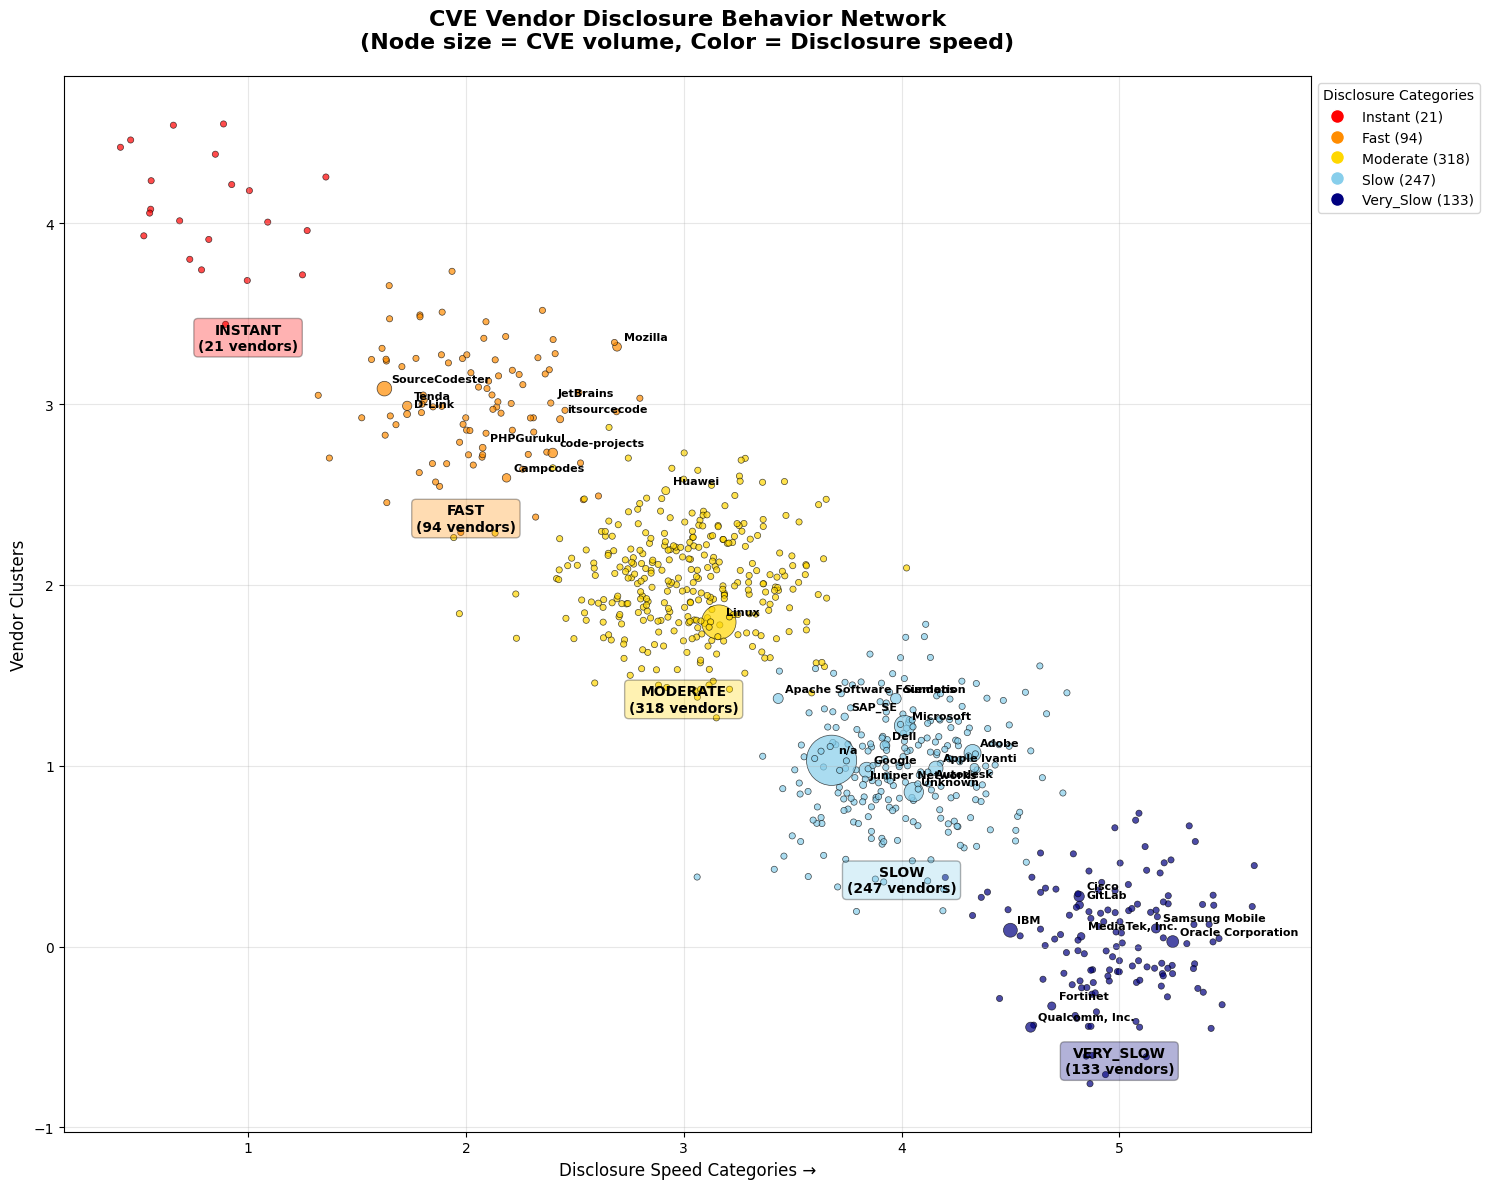

In [0]:
  print("🎨 Step 8: Creating vendor disclosure network visualization...")

  # Convert our network data to graph format
  print("🔗 Converting network to graph format...")

  # Create node list with vendor properties
  nodes = []
  for vendor in vendor_data:
      nodes.append({
          'id': vendor['vendor'],
          'cve_count': vendor['cve_count'],
          'avg_disclosure_days': vendor['avg_disclosure_days'],
          'category': vendor['category'],
          'size': vendor['cve_count'] / 10,  # Node size based on CVE volume
      })

  # Create edge list from our vendor_edges
  edges = []
  for edge in vendor_edges[:200]:  # Limit for cleaner visualization
      edges.append({
          'source': edge['vendor1'],
          'target': edge['vendor2'],
          'weight': edge['combined_cve_count'],
          'category': edge['category']
      })

  print(f"📊 Graph: {len(nodes)} nodes, {len(edges)} edges")

  # Create matplotlib visualization
  print("\n🎨 Creating matplotlib network visualization...")

  import matplotlib.pyplot as plt
  import numpy as np

  # Define colors for categories
  node_colors = {
      'instant': '#FF0000',      # Red
      'fast': '#FF8C00',         # Orange  
      'moderate': '#FFD700',     # Gold
      'slow': '#87CEEB',         # Light Blue
      'very_slow': '#000080'     # Navy Blue
  }

  # Create figure
  plt.figure(figsize=(15, 12))

  # Simple scatter plot layout - group by category
  category_positions = {
      'instant': (1, 4),
      'fast': (2, 3),
      'moderate': (3, 2),
      'slow': (4, 1),
      'very_slow': (5, 0)
  }

  # Plot nodes
  x_coords = []
  y_coords = []
  colors = []
  sizes = []
  labels = []

  for i, node in enumerate(nodes):
      # Base position from category
      base_x, base_y = category_positions[node['category']]

      # Add some random scatter within category
      x = base_x + np.random.normal(0, 0.3)
      y = base_y + np.random.normal(0, 0.3)

      x_coords.append(x)
      y_coords.append(y)
      colors.append(node_colors[node['category']])
      sizes.append(builtins.max(20, node['cve_count'] / 5))  # Size based on CVE count

      # Label major vendors
      if node['cve_count'] > 100:
          labels.append((x, y, node['id']))

  # Plot the scatter
  plt.scatter(x_coords, y_coords, c=colors, s=sizes, alpha=0.7, edgecolors='black', linewidth=0.5)

  # Add labels for major vendors
  for x, y, label in labels:
      plt.annotate(label, (x, y), xytext=(5, 5), textcoords='offset points',
                  fontsize=8, fontweight='bold')

  # Add category labels
  for category, (x, y) in category_positions.items():
      plt.text(x, y-0.7, f"{category.upper()}\n({len([n for n in nodes if n['category'] == category])} vendors)",
               ha='center', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", facecolor=node_colors[category], alpha=0.3))

  plt.title('CVE Vendor Disclosure Behavior Network\n(Node size = CVE volume, Color = Disclosure speed)',
            fontsize=16, fontweight='bold', pad=20)

  plt.xlabel('Disclosure Speed Categories →', fontsize=12)
  plt.ylabel('Vendor Clusters', fontsize=12)

  # Create legend
  legend_elements = []
  for category, color in node_colors.items():
      count = len([n for n in nodes if n['category'] == category])
      legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                      markerfacecolor=color, markersize=10,
                                      label=f'{category.title()} ({count})'))

  plt.legend(handles=legend_elements, title='Disclosure Categories',
            loc='upper left', bbox_to_anchor=(1, 1))

  plt.grid(True, alpha=0.3)
  plt.tight_layout()

  # Show network statistics
  print("📊 Vendor Disclosure Network:")
  print("🔴 Red = Instant disclosure (0 days)")
  print("🟠 Orange = Fast disclosure (1-7 days)")
  print("🟡 Gold = Moderate disclosure (8-30 days)")
  print("🔵 Light Blue = Slow disclosure (31-90 days)")
  print("🔷 Navy = Very slow disclosure (90+ days)")
  print(f"\n📈 Network: {len(nodes)} vendors, {len(edges)} connections")

  plt.show()

Step 1: Load and Filter Data

In [0]:
# -----------------------------------------------------------
# BRONZE LAYER DELIVERABLES GENERATOR
# -----------------------------------------------------------
import os

try:
    table_name = "cve_bronze.records"
    details = spark.sql(f"DESCRIBE DETAIL {table_name}").collect()[0]
    table_path = details['location']
    
    print(f"📍 Table found at: {table_path}")
    
    print("\n" + "="*50)
    print("📸 SCREENSHOT 1: RECORD COUNT")
    print("="*50)
    count = spark.table(table_name).count()
    print(f"📊 Total Records: {count:,}")
    
    print("\n" + "="*50)
    print("📸 SCREENSHOT 2: PHYSICAL FILES")
    print("="*50)
    local_path = table_path.replace("dbfs:", "/dbfs")
    if os.path.exists(local_path):
        files = os.listdir(local_path)
        print(f"📂 Files in {table_path}:")
        for f in files[:7]:
            print(f"  - {f}")
        if len(files) > 7: print(f"  ... ({len(files)-7} more files)")
    else:
        print("⚠️ Could not list files (Path access restricted). The DESCRIBE output below is sufficient proof.")

    print("\n" + "="*50)
    print("📸 SCREENSHOT 3: TABLE DETAILS")
    print("="*50)
    display(spark.sql(f"DESCRIBE DETAIL {table_name}"))

    print("\n" + "="*50)
    print("📸 SCREENSHOT 4: DATA QUALITY CHECKS")
    print("="*50)
    print("✅ Running Quality Assertions...")
    
    # A. Count Check
    if count >= 30000: print(f"  [PASS] Record Count: {count:,} (>= 30,000)")
    else: print(f"  [FAIL] Record Count: {count:,} (< 30,000)")
    
    # B. Null Check
    nulls = spark.table(table_name).filter("cveMetadata IS NULL").count()
    if nulls == 0: print(f"  [PASS] Null Metadata: 0 records found")
    else: print(f"  [FAIL] Null Metadata: {nulls} records found")
    
    # C. Uniqueness Check
    unique_ids = spark.table(table_name).select("id").distinct().count()
    if unique_ids == count: print(f"  [PASS] Unique IDs: {unique_ids:,} (all records unique)")
    else: print(f"  [FAIL] Unique IDs: {unique_ids:,} (duplicates found)")

except Exception as e:
    print(f"❌ Error: {e}")

In [0]:
from pyspark.sql.functions import col, get_json_object, to_timestamp, year

# 1. Load the data created by your previous notebook
# Note: Ensure DELTA_BRONZE_2024_PATH matches the path from your previous run
# (e.g., "/Volumes/workspace/default/cve_demo/bronze/2024_Nov13")
raw_bronze_df = spark.read.format("delta").load(DELTA_BRONZE_2024_PATH)

# 2. Filter to 2024 only using the cveMetadata.datePublished field
# We extract the date string from the JSON and cast it to a timestamp to check the year
bronze_filtered_df = raw_bronze_df.filter(
    year(to_timestamp(get_json_object(col("cveMetadata"), "$.datePublished"))) == 2024
)

print(f"Record count after strict date filtering: {bronze_filtered_df.count()}")

Record count after strict date filtering: 32924


Step 2: Register the Table

In [0]:
# 1. Create the database (schema) if it doesn't exist
spark.sql("CREATE SCHEMA IF NOT EXISTS cve_bronze")

# 2. Write the filtered data and register the table
# We use 'overwrite' to ensure the table is fresh if you re-run the pipeline
(bronze_filtered_df.write
    .format("delta")
    .mode("overwrite")
    .option("mergeSchema", "true")
    .saveAsTable("cve_bronze.records")
)

print("✅ Table 'cve_bronze.records' successfully registered.")

✅ Table 'cve_bronze.records' successfully registered.


Step 3: Data Quality Checks

In [0]:
# 1. Check Total Count (Must be >= 30,000)
total_count = spark.table("cve_bronze.records").count()
print(f"Total Records: {total_count:,}")

if total_count >= 30000:
    print("✅ Quality Check Passed: Volume is sufficient (>= 30,000)")
else:
    print("❌ Quality Check Failed: Insufficient volume")

# 2. Check for Null CVE IDs
# We need to parse the ID from the metadata to check it
null_id_count = spark.table("cve_bronze.records") \
    .filter(get_json_object(col("cveMetadata"), "$.cveId").isNull()) \
    .count()

if null_id_count == 0:
    print("✅ Quality Check Passed: No Null CVE IDs found")
else:
    print(f"❌ Quality Check Failed: {null_id_count} Null IDs found")

# 3. Check for Uniqueness
# Compare total count vs distinct ID count
distinct_count = spark.table("cve_bronze.records") \
    .select(get_json_object(col("cveMetadata"), "$.cveId")) \
    .distinct() \
    .count()

if total_count == distinct_count:
    print("✅ Quality Check Passed: All records are unique")
else:
    print(f"❌ Quality Check Failed: {total_count - distinct_count} duplicates detected")

Total Records: 32,924
✅ Quality Check Passed: Volume is sufficient (>= 30,000)
✅ Quality Check Passed: No Null CVE IDs found
✅ Quality Check Passed: All records are unique


Step 4: Final Output Verification

In [0]:
# Show Delta table details (location, format, size, etc.)
spark.sql("DESCRIBE DETAIL cve_bronze.records").display()

# Show a sample to verify content
spark.sql("SELECT * FROM cve_bronze.records LIMIT 5").display()

format,id,name,description,location,createdAt,lastModified,partitionColumns,clusteringColumns,numFiles,sizeInBytes,properties,minReaderVersion,minWriterVersion,tableFeatures,statistics,clusterByAuto
delta,ce0ea685-b5fc-4a35-ac7f-630ffeb68511,workspace.cve_bronze.records,null,,2025-11-17T08:50:30.556Z,2025-11-17T08:50:34.000Z,List(),List(),1,15164129,"Map(delta.parquet.compression.codec -> zstd, delta.enableDeletionVectors -> true)",3,7,"List(appendOnly, deletionVectors, invariants)","Map(numRowsDeletedByDeletionVectors -> 0, numDeletionVectors -> 0)",false


dataType cveMetadata containers dataVersion _ingestion_timestamp _ingestion_date _year _record_id CVE_RECORD {"state": "PUBLISHED", "cveId": "CVE-2024-41305", "assignerOrgId": "8254265b-2729-46b6-b9e3-3dfca2d5bfca", "assignerShortName": "mitre", "dateUpdated": "2024-08-02T04:46:52.073Z", "dateReserved": "2024-07-18T00:00:00", "datePublished": "2024-07-30T00:00:00"} {"cna": {"providerMetadata": {"orgId": "8254265b-2729-46b6-b9e3-3dfca2d5bfca", "shortName": "mitre", "dateUpdated": "2024-07-30T17:46:27.387912"}, "descriptions": [{"lang": "en", "value": "A Server-Side Request Forgery (SSRF) in the Plugins Page of WonderCMS v3.4.3 allows attackers to force the application to make arbitrary requests via injection of crafted URLs into the pluginThemeUrl parameter."}], "affected": [{"vendor": "n/a", "product": "n/a", "versions": [{"version": "n/a", "status": "affected"}]}], "references": [{"url": "https://github.com/patrickdeanramos/WonderCMS-version-3.4.3-is-vulnerable-to-Server-Side-Request-Forgery"}], "problemTypes": [{"descriptions": [{"type": "text", "lang": "en", "description": "n/a"}]}]}, "adp": [{"problemTypes": [{"descriptions": [{"type": "CWE", "cweId": "CWE-352", "lang": "en", "description": "CWE-352 Cross-Site Request Forgery (CSRF)"}]}], "affected": [{"vendor": "wondercms", "product": "wondercms", "cpes": ["cpe:2.3:a:wondercms:wondercms:3.4.3:*:*:*:*:*:*:*"], "defaultStatus": "unknown", "versions": [{"version": "3.4.3", "status": "affected"}]}], "metrics": [{"cvssV3_1": {"scope": "CHANGED", "version": "3.1", "baseScore": 7.1, "attackVector": "NETWORK", "baseSeverity": "HIGH", "vectorString": "CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:C/C:L/I:L/A:L", "integrityImpact": "LOW", "userInteraction": "REQUIRED", "attackComplexity": "LOW", "availabilityImpact": "LOW", "privilegesRequired": "NONE", "confidentialityImpact": "LOW"}}, {"other": {"type": "ssvc", "content": {"timestamp": "2024-07-30T18:12:14.987173Z", "id": "CVE-2024-41305", "options": [{"Exploitation": "poc"}, {"Automatable": "no"}, {"Technical Impact": "partial"}], "role": "CISA Coordinator", "version": "2.0.3"}}}], "title": "CISA ADP Vulnrichment", "providerMetadata": {"orgId": "134c704f-9b21-4f2e-91b3-4a467353bcc0", "shortName": "CISA-ADP", "dateUpdated": "2024-07-30T18:27:57.767Z"}}, {"providerMetadata": {"orgId": "af854a3a-2127-422b-91ae-364da2661108", "shortName": "CVE", "dateUpdated": "2024-08-02T04:46:52.073Z"}, "title": "CVE Program Container", "references": [{"url": "https://github.com/patrickdeanramos/WonderCMS-version-3.4.3-is-vulnerable-to-Server-Side-Request-Forgery", "tags": ["x_transferred"]}]}]} 5.1 2025-11-17T08:30:44.529Z 2025-11-17 2024 0 CVE_RECORD {"cveId": "CVE-2024-41108", "assignerOrgId": "a0819718-46f1-4df5-94e2-005712e83aaa", "state": "PUBLISHED", "assignerShortName": "GitHub_M", "dateReserved": "2024-07-15T15:53:28.321Z", "datePublished": "2024-07-31T19:04:59.847Z", "dateUpdated": "2024-07-31T20:16:30.160Z"} {"cna": {"title": "FOG Sensitive Information Disclosure", "problemTypes": [{"descriptions": [{"cweId": "CWE-200", "lang": "en", "description": "CWE-200: Exposure of Sensitive Information to an Unauthorized Actor", "type": "CWE"}]}], "metrics": [{"cvssV3_1": {"attackComplexity": "LOW", "attackVector": "NETWORK", "availabilityImpact": "NONE", "baseScore": 7.5, "baseSeverity": "HIGH", "confidentialityImpact": "HIGH", "integrityImpact": "NONE", "privilegesRequired": "NONE", "scope": "UNCHANGED", "userInteraction": "NONE", "vectorString": "CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N", "version": "3.1"}}], "references": [{"name": "https://github.com/FOGProject/fogproject/security/advisories/GHSA-p3f9-4jj4-fm2g", "tags": ["x_refsource_CONFIRM"], "url": "https://github.com/FOGProject/fogproject/security/advisories/GHSA-p3f9-4jj4-fm2g"}, {"name": "https://github.com/FOGProject/fogproject/blob/a4bb1bf39ac53c3cbe623576915fbc3b5c80a00f/packages/web/service/hostinfo.php", "tags": ["x_refsource_MISC"], "url": "https://github.com/FOGProject/fogproject/blob/a4bb

In [0]:
from pyspark.sql.functions import col, get_json_object, to_timestamp, year

# 1. Create the database if it doesn't exist
spark.sql("CREATE SCHEMA IF NOT EXISTS cve_bronze")

# 2. Load your existing data (from the path you defined in your notebook)
# Note: Your HTML defined DELTA_BRONZE_2024_PATH, we reuse that here.
raw_df = spark.read.format("delta").load(DELTA_BRONZE_2024_PATH)

# 3. Apply Strict Filtering (Rubric Requirement 1)
# We parse the JSON 'cveMetadata' column to get the real publish date
bronze_filtered_df = raw_df.filter(
    year(to_timestamp(get_json_object(col("cveMetadata"), "$.datePublished"))) == 2024
)

print(f"Count after strict date filtering: {bronze_filtered_df.count()}")

# 4. Register the Table (Rubric Requirement 2)
# We use saveAsTable to register it in the Metastore
(bronze_filtered_df.write
    .format("delta")
    .mode("overwrite")
    .option("mergeSchema", "true")
    .saveAsTable("cve_bronze.records")
)

print("✅ Table 'cve_bronze.records' successfully registered.")

Count after strict date filtering: 32924
✅ Table 'cve_bronze.records' successfully registered.


In [0]:
# 1. Volume Check
final_count = spark.table("cve_bronze.records").count()
assert final_count >= 30000, f"❌ Insufficient records: {final_count}"
print(f"✅ Volume Check Passed: {final_count} records (>= 30,000)")

# 2. Null ID Check
# We parse the ID from metadata to ensure it exists
null_ids = spark.table("cve_bronze.records") \
    .filter(get_json_object(col("cveMetadata"), "$.cveId").isNull()) \
    .count()
assert null_ids == 0, f"❌ Found {null_ids} records with Null CVE IDs!"
print("✅ Null Check Passed: No null CVE IDs found.")

# 3. Uniqueness Check
distinct_ids = spark.table("cve_bronze.records") \
    .select(get_json_object(col("cveMetadata"), "$.cveId")) \
    .distinct() \
    .count()
assert final_count == distinct_ids, f"❌ Duplicates detected! Total: {final_count}, Unique: {distinct_ids}"
print("✅ Uniqueness Check Passed: All records are unique.")

✅ Volume Check Passed: 32924 records (>= 30,000)
✅ Null Check Passed: No null CVE IDs found.
✅ Uniqueness Check Passed: All records are unique.


In [0]:
# Show technical table details (location, size, format)
spark.sql("DESCRIBE DETAIL cve_bronze.records").display()

# Show a sample to prove data integrity
spark.sql("SELECT * FROM cve_bronze.records LIMIT 5").display()

format,id,name,description,location,createdAt,lastModified,partitionColumns,clusteringColumns,numFiles,sizeInBytes,properties,minReaderVersion,minWriterVersion,tableFeatures,statistics,clusterByAuto
delta,ce0ea685-b5fc-4a35-ac7f-630ffeb68511,workspace.cve_bronze.records,null,,2025-11-17T08:50:30.556Z,2025-11-17T15:42:01.000Z,List(),List(),1,15164129,"Map(delta.parquet.compression.codec -> zstd, delta.enableDeletionVectors -> true)",3,7,"List(appendOnly, deletionVectors, invariants)","Map(numRowsDeletedByDeletionVectors -> 0, numDeletionVectors -> 0)",false


dataType cveMetadata containers dataVersion _ingestion_timestamp _ingestion_date _year _record_id CVE_RECORD {"state": "PUBLISHED", "cveId": "CVE-2024-41305", "assignerOrgId": "8254265b-2729-46b6-b9e3-3dfca2d5bfca", "assignerShortName": "mitre", "dateUpdated": "2024-08-02T04:46:52.073Z", "dateReserved": "2024-07-18T00:00:00", "datePublished": "2024-07-30T00:00:00"} {"cna": {"providerMetadata": {"orgId": "8254265b-2729-46b6-b9e3-3dfca2d5bfca", "shortName": "mitre", "dateUpdated": "2024-07-30T17:46:27.387912"}, "descriptions": [{"lang": "en", "value": "A Server-Side Request Forgery (SSRF) in the Plugins Page of WonderCMS v3.4.3 allows attackers to force the application to make arbitrary requests via injection of crafted URLs into the pluginThemeUrl parameter."}], "affected": [{"vendor": "n/a", "product": "n/a", "versions": [{"version": "n/a", "status": "affected"}]}], "references": [{"url": "https://github.com/patrickdeanramos/WonderCMS-version-3.4.3-is-vulnerable-to-Server-Side-Request-Forgery"}], "problemTypes": [{"descriptions": [{"type": "text", "lang": "en", "description": "n/a"}]}]}, "adp": [{"problemTypes": [{"descriptions": [{"type": "CWE", "cweId": "CWE-352", "lang": "en", "description": "CWE-352 Cross-Site Request Forgery (CSRF)"}]}], "affected": [{"vendor": "wondercms", "product": "wondercms", "cpes": ["cpe:2.3:a:wondercms:wondercms:3.4.3:*:*:*:*:*:*:*"], "defaultStatus": "unknown", "versions": [{"version": "3.4.3", "status": "affected"}]}], "metrics": [{"cvssV3_1": {"scope": "CHANGED", "version": "3.1", "baseScore": 7.1, "attackVector": "NETWORK", "baseSeverity": "HIGH", "vectorString": "CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:C/C:L/I:L/A:L", "integrityImpact": "LOW", "userInteraction": "REQUIRED", "attackComplexity": "LOW", "availabilityImpact": "LOW", "privilegesRequired": "NONE", "confidentialityImpact": "LOW"}}, {"other": {"type": "ssvc", "content": {"timestamp": "2024-07-30T18:12:14.987173Z", "id": "CVE-2024-41305", "options": [{"Exploitation": "poc"}, {"Automatable": "no"}, {"Technical Impact": "partial"}], "role": "CISA Coordinator", "version": "2.0.3"}}}], "title": "CISA ADP Vulnrichment", "providerMetadata": {"orgId": "134c704f-9b21-4f2e-91b3-4a467353bcc0", "shortName": "CISA-ADP", "dateUpdated": "2024-07-30T18:27:57.767Z"}}, {"providerMetadata": {"orgId": "af854a3a-2127-422b-91ae-364da2661108", "shortName": "CVE", "dateUpdated": "2024-08-02T04:46:52.073Z"}, "title": "CVE Program Container", "references": [{"url": "https://github.com/patrickdeanramos/WonderCMS-version-3.4.3-is-vulnerable-to-Server-Side-Request-Forgery", "tags": ["x_transferred"]}]}]} 5.1 2025-11-17T08:30:44.529Z 2025-11-17 2024 0 CVE_RECORD {"cveId": "CVE-2024-41108", "assignerOrgId": "a0819718-46f1-4df5-94e2-005712e83aaa", "state": "PUBLISHED", "assignerShortName": "GitHub_M", "dateReserved": "2024-07-15T15:53:28.321Z", "datePublished": "2024-07-31T19:04:59.847Z", "dateUpdated": "2024-07-31T20:16:30.160Z"} {"cna": {"title": "FOG Sensitive Information Disclosure", "problemTypes": [{"descriptions": [{"cweId": "CWE-200", "lang": "en", "description": "CWE-200: Exposure of Sensitive Information to an Unauthorized Actor", "type": "CWE"}]}], "metrics": [{"cvssV3_1": {"attackComplexity": "LOW", "attackVector": "NETWORK", "availabilityImpact": "NONE", "baseScore": 7.5, "baseSeverity": "HIGH", "confidentialityImpact": "HIGH", "integrityImpact": "NONE", "privilegesRequired": "NONE", "scope": "UNCHANGED", "userInteraction": "NONE", "vectorString": "CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N", "version": "3.1"}}], "references": [{"name": "https://github.com/FOGProject/fogproject/security/advisories/GHSA-p3f9-4jj4-fm2g", "tags": ["x_refsource_CONFIRM"], "url": "https://github.com/FOGProject/fogproject/security/advisories/GHSA-p3f9-4jj4-fm2g"}, {"name": "https://github.com/FOGProject/fogproject/blob/a4bb1bf39ac53c3cbe623576915fbc3b5c80a00f/packages/web/service/hostinfo.php", "tags": ["x_refsource_MISC"], "url": "https://github.com/FOGProject/fogproject/blob/a4bb